# <center>Instituto Tecnológico de Estudios Superiores de Occidente</center>



<img style="float: center" src="logo-ITESO-png.png" width="350px" height="125px"/>




#### <center>"Simulación Matemática"</center>


### <center>SIMULACIÓN DE UN PORTAFOLIO DE INVERSIÓN</center>

.



**<center>Profesor: Gabriel Alejando Morales Ruiz</center>**

.



**<center>Leonardo Rodríguez Hernández - 741983</center>**



**<center>Valenzuela Lafarga Mariana - 749770</center>**



**<center>Nancy Woolrich Sorroza - 741983</center>**



.


**<center>22 de abril 2024.</center>**

## <center> Construcción de un portafolio de inversión con programación lineal</center>

### Introducción
    
  
    

### Objetivos

#### 1.1 Objetivo general.

Pronosticar un portaforlio de inversión a un año.

#### 1.2 Objetivos específicos
- Calcular la media y desviación estándar de los rendimientos diarios de las acciones de cada empresa para evaluar su distribución y realizar el pronóstico

- Utilizar el método de aproximación de Montecarlo para simular múltiples escenarios de rendimiento del portafolio de inversión en el próximo año.
- Generar visualizaciones claras y concisas de los resultados del proyecto, incluidas gráficas de desempeño del portafolio y distribuciones de rendimientos simulados.


### Modelo del problema.

Para generar el modelo que pronostique los rendimientos a 1 año se utilizarán los datos diarios del 14 de abril de 2022 a 2023 para poder realizar la comparación con el año 2024 y determinar si el modelo planteado es válido, los datos son sacados de Yahoo finance.

Las acciones con las que se trabajará en el portafolio son:

>- **AAPL:** Apple Inc. diseña, fabrica y comercializa teléfonos inteligentes, computadoras personales, tabletas, dispositivos portátiles y accesorios en todo el mundo.Es la empresa de tecnología más grande del mundo.

>- **AZO:** AutoZone, Inc. vende y distribuye repuestos y accesorios automotrices en Estados Unidos, México y Brasil. La empresa ofrece diversos productos para automóviles, vehículos utilitarios deportivos, camionetas y camiones ligeros.


>- **VRTX:** Ertex Pharmaceuticals Incorporated, una empresa de biotecnología, se dedica al desarrollo y comercialización de terapias para el tratamiento de la fibrosis quística (FQ).


>- **OXY:** Occidental Petroleum Corporation, junto con sus subsidiarias, se dedica a la adquisición, exploración y desarrollo de propiedades de petróleo y gas en los Estados Unidos, Medio Oriente y el norte de África.


>- **WMT:** Walmart Inc. se dedica a la operación de ventas al por menor, al por mayor, otras unidades y comercio electrónico en todo el mundo. La empresa opera a través de tres segmentos: Walmart U.S., Walmart International y Sam's Club.

Se decidieron escoger acciones que fueran medianamente estables con volatilidades no tan altas para que el modelo tenga un menor grado de error. 


In [4]:
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
yf.pdr_override()

In [5]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [6]:
tickers = ["AAPL", "AZO", "VRTX", "OXY", "WMT"]
start_date = "2023-04-14"
end_date= "2024-04-14"
closes = get_adj_closes(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date
)
closes.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AZO,OXY,VRTX,WMT
Date,,,,,
2023-04-14,164.332840,2638.320068,63.675762,333.519989,48.783424
2023-04-17,164.352737,2665.409912,62.154964,327.739990,49.125118
2023-04-18,165.586166,2681.649902,62.214214,325.149994,49.233536
2023-04-19,166.740005,2663.159912,61.690826,328.450012,49.286110
2023-04-20,165.765182,2701.840088,61.256313,329.149994,49.601521


.

- **Modelo**

El siguente paso es obtener el rendimiento diario, para ello se va a observar la distribución de los rendimientos y así comprobar que se asemejen a una distribucion normal.

.

In [9]:
ret = closes.pct_change().dropna()
ret.head()

Ticker,AAPL,AZO,OXY,VRTX,WMT
Date,,,,,
2023-04-17,0.000121,0.010268,-0.023883,-0.017330,0.007004
2023-04-18,0.007505,0.006093,0.000953,-0.007903,0.002207
2023-04-19,0.006968,-0.006895,-0.008413,0.010149,0.001068
2023-04-20,-0.005846,0.014524,-0.007043,0.002131,0.006400
2023-04-21,-0.009781,-0.007562,-0.002579,0.005894,0.005034


En la siguiente gráfica podemos ver que las distribuciones de los rendimientos se asemejan a una normal

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'AZO'}>],
       [<Axes: title={'center': 'OXY'}>,
        <Axes: title={'center': 'VRTX'}>],
       [<Axes: title={'center': 'WMT'}>, <Axes: >]], dtype=object)

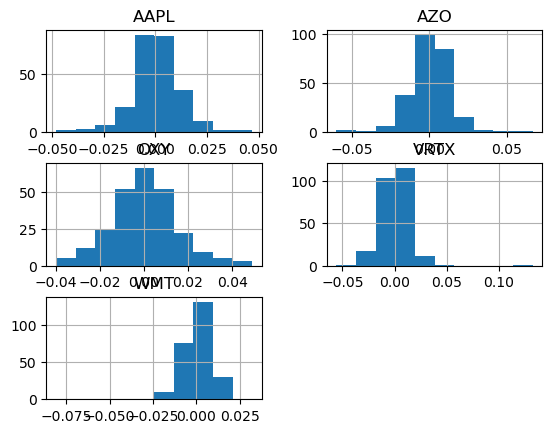

In [10]:
ret.hist()


Ahora se van a obtener los datos de media y desviación estándar para cada uno de estos activos y así tener los parámetros de las distribuciones.

In [7]:
summary_daily = pd.DataFrame({
    "mean": ret.mean(),
    "vol": ret.std()
}).T
summary_daily

Ticker,AAPL,AZO,OXY,VRTX,WMT
mean,0.000362,0.000556,0.000429,0.000803,0.000883
vol,0.012263,0.013593,0.014709,0.015070,0.009479


Una vez obtenidos los parámetros de media y desviación de cada uno de los activos se va a realizar la simulación a 1 año con la siguiente función.

In [11]:
def simR(media,std,start,dias,N):
    sim_R= np.random.normal(media, std,size=(dias,N))+1
    fechas= pd.date_range(start,periods=dias)
    return pd.DataFrame(sim_R,index=fechas)

- **Explicación y limitaciones**

El modelo planteado anteriormente pretende obtener el rendimiento pronosticado del portafolio planteado a 1 año, esto se obtiene mediamente las simulaciones de 365 dias según la media y la desviación de cada activo, después se obtiene el precio final y para determinar rendimiento total.

Las limitaciones que presenta este modelo es que los activos pueden no siempre seguir la misma tendencia, y si son activos muy volátiles su media y su desviación estandar cambia drásticamente de un periodo a otro, por lo que puede no ser un modelo tan certero para todo tipo de activos.

### Solución del modelo



Primeramente se crea una variable para cada desviación estándar y media de cada empresa.

In [20]:
aaplmean = ret["AAPL"].mean()
aaplstd = ret["AAPL"].std()
wmtmean = ret["WMT"].mean()
wmtstd = ret["WMT"].std()
azomean = ret["AZO"].mean()
azostd = ret["AZO"].std()
oxymean = ret["OXY"].mean()
oxystd = ret["OXY"].std()
vrtxmean = ret["VRTX"].mean()
vrtxstd = ret["VRTX"].std()

Se simula para cada Empresa el rendimiento a 1 año:

**APPLE**

In [21]:
#Simulación del rendimiento a 1 año
sim_R_aapl =simR(aaplmean,aaplstd, "2024-04-22", 365, 1000)
sim_R_aapl

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,0.995253,1.007987,1.009149,1.002981,0.993282,0.973738,1.013621,0.991275,1.009304,0.990263,...,1.009350,0.981079,1.001404,0.997473,1.007101,0.990060,0.996708,1.024844,0.993236,0.992124
2024-04-23,1.001788,1.005021,1.011383,1.017663,1.002386,1.005817,1.000160,0.990810,1.004040,1.001919,...,0.993987,0.987796,0.998669,1.004594,1.016894,1.011561,0.999713,1.008710,1.001464,1.018711
2024-04-24,0.995937,1.016584,1.009334,0.988461,1.005961,1.013823,1.021648,0.999071,1.023325,1.001247,...,0.997883,1.013432,1.014300,1.008455,1.012577,0.999355,0.999716,0.996404,0.996985,1.027493
2024-04-25,0.985030,1.011775,1.006927,0.997392,0.992198,1.001640,1.013204,1.000507,0.986849,1.014606,...,1.002869,1.001852,1.016216,1.001279,0.973358,0.995495,1.028017,1.007822,1.021976,1.000606
2024-04-26,1.010852,1.005907,1.004219,0.986897,0.988149,1.000493,0.982284,1.002538,0.985531,0.993042,...,1.003410,0.997057,0.992768,1.003105,0.985687,0.988493,0.996947,1.007732,1.006144,1.008073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.999254,1.006005,0.994541,1.007637,1.001013,1.002612,0.983328,0.986631,1.007157,1.007679,...,1.019738,0.991020,1.001801,0.978301,1.009954,0.998401,1.000115,1.010302,0.992356,0.979352
2025-04-18,0.988975,1.009090,0.985868,1.014168,1.003042,0.999199,0.996411,1.002309,0.992522,0.993279,...,0.989498,0.994976,0.998130,0.994296,0.979913,1.003211,0.984991,0.965385,1.010470,0.999384
2025-04-19,1.010023,0.992516,0.994280,1.004082,1.022649,0.983520,1.011212,0.997874,0.989119,0.989327,...,0.984748,0.998543,1.003775,1.010892,0.994927,1.025104,1.016799,1.019820,0.989344,1.016855
2025-04-20,0.999859,1.015503,0.985371,0.980979,0.997057,1.010453,0.995629,1.007053,1.015841,1.002992,...,0.978920,0.992854,0.995225,0.999760,0.997797,1.004466,1.007766,1.014009,1.010951,1.011045


**WALMART**

In [22]:
sim_R_wmt =simR(wmtmean,wmtstd, "2024-04-22", 365, 1000)
sim_R_wmt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.009835,0.992903,1.021561,1.020834,0.987479,1.005489,0.988899,0.990697,1.016297,1.018956,...,0.979413,1.015198,0.992229,1.000120,1.008138,0.993149,0.993029,0.999081,0.997510,0.984861
2024-04-23,1.001818,0.997032,1.006461,0.997986,0.994342,1.002335,0.998791,1.001054,0.992801,0.994980,...,0.994829,0.993749,0.991968,1.006571,1.013317,0.989994,1.006697,0.994119,0.993921,1.003458
2024-04-24,1.012975,1.000351,1.008248,0.999119,1.005921,1.011105,0.996208,1.011841,0.980131,1.008938,...,0.994030,1.011527,1.005234,1.019568,1.007949,0.998436,1.017072,0.999592,1.005867,0.993078
2024-04-25,1.017307,0.993948,1.004541,0.992368,0.993690,1.001517,1.000189,1.003395,1.006329,0.991328,...,1.017438,1.008215,1.000745,1.001678,1.018118,0.997910,0.994146,0.990522,1.016725,0.997639
2024-04-26,1.012622,0.998464,1.016432,1.004505,1.014676,0.998584,1.004115,1.003560,1.008726,1.000891,...,0.978882,1.015417,1.004195,1.011758,0.979610,0.998985,0.989388,0.998329,0.985594,1.009726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.994870,1.002199,1.004139,0.996552,1.005573,1.009210,1.003220,1.009266,1.001018,1.020086,...,0.988235,1.004590,1.008100,1.015125,0.995421,0.999805,1.009038,1.001791,1.018672,1.016542
2025-04-18,0.983541,1.024739,0.993204,1.008632,1.002771,1.002350,0.996016,1.011110,0.994347,0.986273,...,0.986323,0.994784,0.999960,0.992594,0.991699,1.008989,0.998279,1.002546,1.007975,1.002686
2025-04-19,1.005367,0.992071,1.004483,0.996263,0.998822,0.997455,0.977216,0.978387,1.019206,0.996475,...,1.002639,0.983519,1.011346,0.985317,1.021415,1.002410,1.002992,0.986606,1.019013,1.003466
2025-04-20,1.000469,0.996309,1.006773,1.002341,1.001904,0.998081,1.009265,1.007164,1.006353,0.979259,...,1.000069,0.993631,1.006961,0.995957,1.012169,1.010149,0.989507,1.005057,1.013725,1.000131


**AUTOZONE**

In [23]:
sim_R_azo =simR(azomean,azostd, "2024-04-22", 365, 1000)
sim_R_azo

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.021708,0.991748,1.005870,1.006418,0.999989,0.972160,0.999873,1.009358,0.992709,1.007639,...,0.997040,0.992745,0.990003,1.001730,0.993804,0.979741,0.995520,0.992821,1.016452,0.982875
2024-04-23,0.998335,1.012911,1.014376,1.020959,0.991168,1.013655,0.991383,0.999184,1.030064,1.016927,...,0.996230,0.991590,1.003124,1.002085,1.013672,0.982010,0.982460,1.020312,1.019466,1.006914
2024-04-24,1.015674,1.018540,0.989287,1.002618,0.984683,1.002359,0.998434,1.016758,1.012028,0.983164,...,0.967654,0.994053,0.972969,1.001574,0.995063,1.027881,0.996872,0.964761,1.018064,1.007077
2024-04-25,0.983325,1.006400,0.987849,1.002637,0.996306,1.006440,0.985616,0.980017,0.985386,0.993494,...,0.985538,1.022168,0.998706,1.018579,1.006304,0.997242,1.018906,0.989495,1.012028,0.992601
2024-04-26,0.988807,0.988524,0.977278,0.998810,1.015750,1.001303,0.977765,0.977749,1.005870,1.027365,...,0.974195,0.976884,0.983492,1.003647,1.026636,0.997452,0.997615,1.010640,1.011596,0.985313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.991627,1.024667,1.003450,1.016073,0.987380,1.005657,1.001090,1.001043,1.001567,0.997702,...,0.993752,1.022935,1.017236,0.997827,0.981693,0.988942,1.011921,1.009100,1.014588,1.006422
2025-04-18,1.007284,0.997416,0.991682,0.971118,1.004598,0.977584,1.016747,0.973557,1.013149,0.994935,...,0.996655,1.027402,1.014916,0.986541,0.995477,1.012596,0.992057,0.992363,1.019417,1.011864
2025-04-19,1.017821,1.016515,0.969689,0.989576,1.014054,0.992663,1.015455,1.020478,1.010700,1.009397,...,0.991004,0.998181,1.011894,0.993749,1.003880,0.999968,0.999565,0.993682,0.992421,1.014268
2025-04-20,1.025140,1.010079,1.017135,1.024386,0.995701,0.993479,0.993914,1.013250,0.984321,1.010399,...,0.999451,1.005846,0.998968,0.999469,1.000173,0.995271,1.006001,0.995375,0.998436,1.019410


**ERTEX PHARMACEUTICALS**

In [24]:
sim_R_vrtx =simR(vrtxmean,vrtxstd, "2024-04-22", 365, 1000)
sim_R_vrtx

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,0.992673,1.036371,0.990652,1.014323,0.996568,1.009764,1.012391,1.006889,1.005944,1.008738,...,0.990584,0.986192,1.001710,0.973543,1.018058,1.004028,1.000285,0.993552,0.994601,0.991754
2024-04-23,0.994950,0.994163,1.003212,1.007670,1.002774,1.009757,1.014472,0.980990,0.983690,1.007148,...,0.990189,1.014034,1.013059,0.965028,0.969950,1.001322,0.988554,0.990916,1.007892,0.992255
2024-04-24,0.992631,1.015173,0.985135,0.992060,0.992003,1.016722,1.001546,0.985085,0.980763,0.977615,...,1.005671,1.020561,1.019873,1.007344,0.975562,0.989922,0.994965,0.978757,1.008637,1.005369
2024-04-25,1.000905,1.002170,1.020453,1.004303,1.003836,1.022141,1.005150,1.001971,1.021836,0.963322,...,1.004258,0.988628,0.991421,1.000140,1.002547,0.991467,1.007980,1.019618,1.048597,1.020872
2024-04-26,0.993813,1.000084,0.985413,1.000055,1.009602,1.019108,0.970770,1.012171,0.994792,1.026531,...,0.994250,1.015642,0.988537,1.000491,0.989111,1.003509,1.005119,0.993594,1.009682,1.003608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,1.017509,1.000263,0.996638,1.023092,1.010256,1.011775,0.983034,1.011757,1.000361,1.010594,...,1.002293,0.974526,0.997179,0.996845,1.004281,0.990821,1.009901,1.038809,0.984033,0.993621
2025-04-18,1.003423,1.000765,0.986689,1.045392,1.009578,0.958958,0.988983,1.017331,1.001894,1.013817,...,1.003978,1.014639,0.987230,1.010639,0.989601,1.018087,0.965911,0.988022,0.993853,1.016633
2025-04-19,0.988766,1.012652,0.983866,1.001472,1.004077,1.029700,1.002217,1.008271,1.006527,0.993233,...,0.993952,1.010037,0.997422,1.002618,1.014533,1.004943,1.002399,0.997806,0.980615,0.991153
2025-04-20,0.973231,1.029942,0.987659,0.978227,1.011028,0.983182,1.007322,0.978791,1.018025,0.998230,...,1.018792,0.985592,1.016230,0.998645,0.974234,0.985204,1.009776,0.990608,0.974108,0.996837


**OCCIDENTAL PETROLEUM CORPORATION**

In [25]:
sim_R_oxy =simR(oxymean,oxystd, "2024-04-22", 365, 1000)
sim_R_oxy

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,0.989396,1.017294,0.999604,0.989117,1.010825,0.988925,0.989109,0.996345,1.014600,1.012106,...,1.002755,0.991424,0.969209,0.994473,0.985724,1.022548,0.985145,0.997908,1.019043,0.990139
2024-04-23,1.038978,1.010359,1.007783,0.997683,1.002405,1.004309,0.983814,1.005112,1.013919,0.981361,...,1.007681,1.026511,0.990152,0.989294,0.992835,0.997988,1.024909,0.996757,1.002821,1.002874
2024-04-24,1.008523,1.016669,1.016359,0.991514,1.019116,0.993205,1.012499,0.996699,1.026312,1.008826,...,0.994384,0.984776,1.009383,1.000056,1.008097,0.993165,0.997142,0.979411,0.999906,0.988649
2024-04-25,1.006720,0.998612,1.004785,0.993542,1.004128,1.007226,0.982716,1.010771,0.977831,0.994418,...,1.014713,1.003744,1.000017,1.008332,1.019708,1.007451,1.031808,0.982135,1.012321,1.011586
2024-04-26,0.995944,0.976284,0.997787,1.026629,1.005724,1.019303,1.000019,1.003461,1.006518,0.997973,...,0.967522,1.024703,1.009505,1.007460,0.992451,0.971475,1.006194,0.992857,0.985390,0.998916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.989151,1.020040,0.993312,1.013190,1.006678,1.011621,0.990433,0.974570,0.991282,1.003894,...,1.031692,0.992516,0.981518,0.991707,0.999761,1.002824,0.994972,0.988974,0.997163,0.986883
2025-04-18,1.012740,0.952575,0.986126,0.997152,1.028311,1.020368,0.998457,1.011346,0.998745,0.971752,...,1.045008,1.015300,1.022254,0.997556,0.990438,1.004295,0.991678,0.980981,1.006507,1.007958
2025-04-19,1.007401,0.990659,1.000260,1.009514,1.004327,1.009725,1.009665,1.003373,1.003376,1.016103,...,0.992386,1.007897,1.007671,1.000181,1.000534,1.008408,1.003295,1.028393,1.008656,1.000441
2025-04-20,1.008797,0.980779,1.002279,1.000688,0.991545,1.007272,1.005227,1.000443,1.004935,1.002462,...,1.020442,1.012930,1.020767,1.013119,0.996124,0.989051,0.995040,0.997019,1.022195,0.988988


In [26]:
ret.iloc[-1]

Ticker
AAPL    0.008627
AZO    -0.014780
OXY    -0.003610
VRTX   -0.009195
WMT     0.000832
Name: 2024-04-12 00:00:00, dtype: float64

**Precios de cierre promedio**

Apple


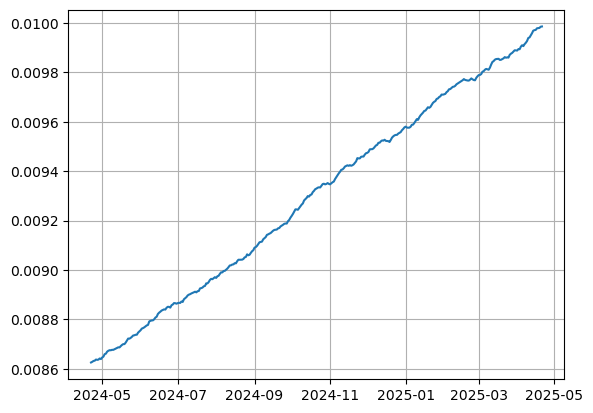

In [27]:
print("Apple")
precios_cierre_aapl=sim_R_aapl.cumprod()*0.008627
mean_aapl = precios_cierre_aapl.mean(axis=1)
plt.plot(mean_aapl)
plt.grid()

Walmart


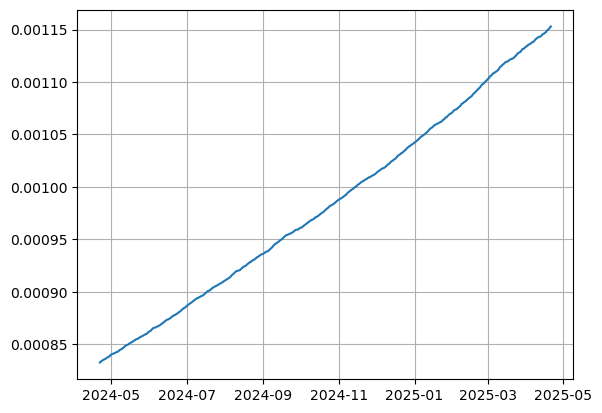

In [28]:
print("Walmart")
precios_cierre_wmt=sim_R_wmt.cumprod()*0.000832
mean_wmt = precios_cierre_wmt.mean(axis=1)
plt.plot(mean_wmt)
plt.grid()

AutoZone


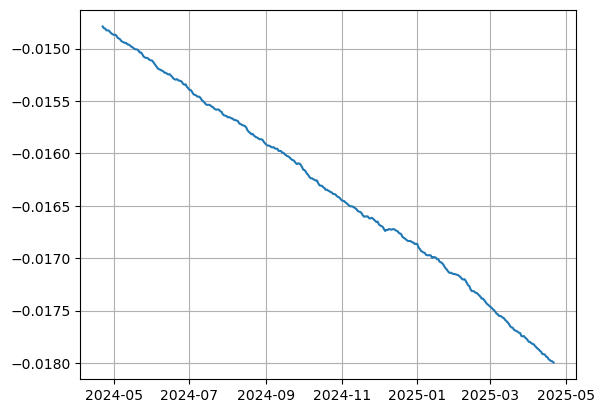

In [29]:
print("AutoZone")
precios_cierre_azo=sim_R_azo.cumprod()*-0.014780
mean_azo = precios_cierre_azo.mean(axis=1)
plt.plot(mean_azo)
plt.grid()

Occidental Petroleum


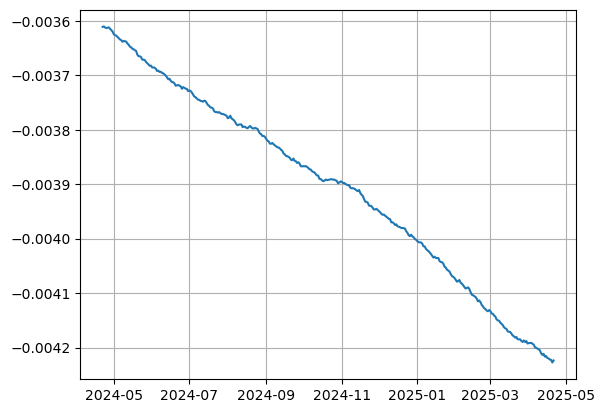

In [30]:
print("Occidental Petroleum")
precios_cierre_oxy=sim_R_oxy.cumprod()*-0.003610
mean_oxy = precios_cierre_oxy.mean(axis=1)
plt.plot(mean_oxy)
plt.grid()

Ertex Pharmaceutics


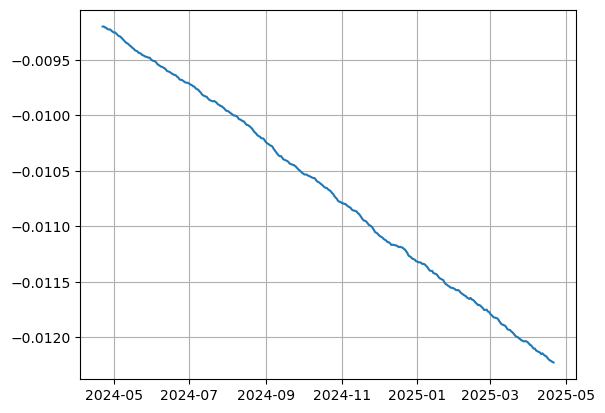

In [31]:
print("Ertex Pharmaceutics")
precios_cierre_vrtx=sim_R_vrtx.cumprod()*-0.009195
mean_vrtx = precios_cierre_vrtx.mean(axis=1)
plt.plot(mean_vrtx)
plt.grid()

**PROBABILIDAD DE AUMENTO DEL 20% EN EL SIGUIENTE AÑO**

In [32]:
# Probabilidad que el dinero crezca un 20%

prob_aapl = ((sim_R_aapl.cumprod()*0.008627*1.20 > 0.008627).mean(axis=1)).mean()*100
prob_wmt = ((sim_R_wmt.cumprod()*0.000832*1.20 > 0.000832).mean(axis=1)).mean()*100
prob_oxy = ((sim_R_oxy.cumprod()*-0.003610*1.20 > -0.003610).mean(axis=1)).mean()*100
prob_azo = ((sim_R_azo.cumprod()*-0.014780*1.20 > -0.014780).mean(axis=1)).mean()*100
prob_vrtx = ((sim_R_vrtx.cumprod()*-0.009195*1.20 > -0.009195).mean(axis=1)).mean()*100

print("APPLE:",prob_aapl,"%")
print("WALMART:",prob_wmt,"%")
print("AUTOZONE:",prob_azo,"%")
print("OCCIDENTAL PETROLEUM:",prob_oxy,"%")
print("ERTEX PHARMACEUTICS:",prob_vrtx,"%")


APPLE: 94.62219178082191 %
WALMART: 99.75123287671232 %
AUTOZONE: 6.294520547945204 %
OCCIDENTAL PETROLEUM: 9.092054794520548 %
ERTEX PHARMACEUTICS: 4.924931506849315 %


## Comparación con el año anterior (2023)

Para observar el crecimiento o decrecimiento de las acciones se compara con los del año anterior.

In [59]:
sim_R_aapl23 =simR(aaplmean,aaplstd, "2023-04-22", 365, 1000)
sim_R_wmt23 =simR(wmtmean,wmtstd, "2023-04-22", 365, 1000)
sim_R_azo23 =simR(azomean,azostd, "2023-04-22", 365, 1000)
sim_R_vrtx23=simR(vrtxmean,vrtxstd, "2023-04-22", 365, 1000)
sim_R_oxy23 =simR(oxymean,oxystd, "2023-04-22", 365, 1000)

In [74]:
aapl.iloc[-1]

Adj Close    165.0
Name: 2024-04-19 00:00:00, dtype: float64

In [79]:
wmt.iloc[-1]

Adj Close    59.529999
Name: 2024-04-19 00:00:00, dtype: float64

In [80]:
azo.iloc[-1]

Adj Close    2985.540039
Name: 2024-04-19 00:00:00, dtype: float64

In [81]:
oxy.iloc[-1]

Adj Close    66.629997
Name: 2024-04-19 00:00:00, dtype: float64

In [78]:
vrtx.iloc[-1]

Adj Close    394.279999
Name: 2024-04-19 00:00:00, dtype: float64

**Precios de cierre promedio del año anterior**

Apple


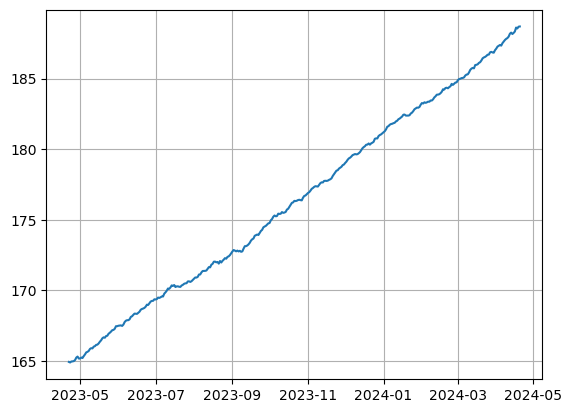

In [82]:
print("Apple")
precios_cierre_aapl=sim_R_aapl23.cumprod()*165.0
mean_aapl = precios_cierre_aapl.mean(axis=1)
plt.plot(mean_aapl)
plt.grid()

Walmart


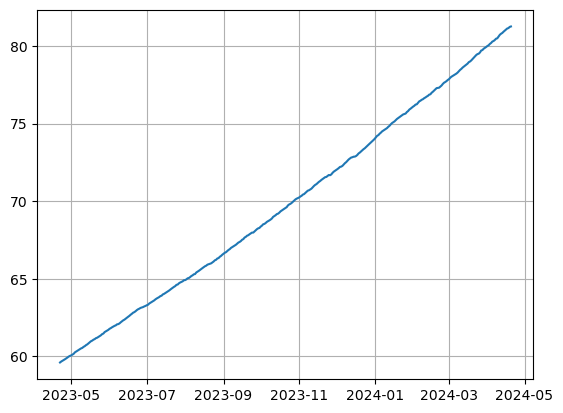

In [83]:
print("Walmart")
precios_cierre_wmt=sim_R_wmt23.cumprod()*59.529999
mean_wmt = precios_cierre_wmt.mean(axis=1)
plt.plot(mean_wmt)
plt.grid()

AutoZone


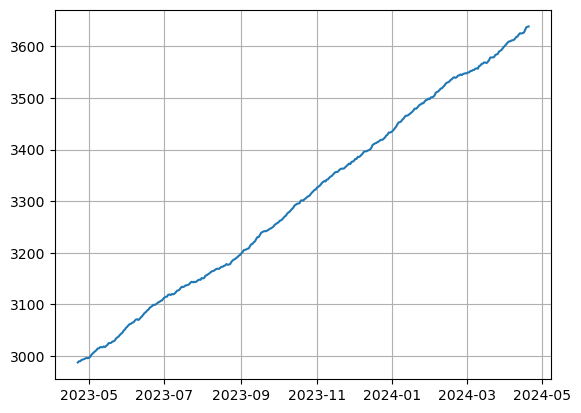

In [92]:
print("AutoZone")
precios_cierre_azo=sim_R_azo23.cumprod()*2985.540039
mean_azo = precios_cierre_azo.mean(axis=1)
plt.plot(mean_azo)
plt.grid()

Occidental Petroleum


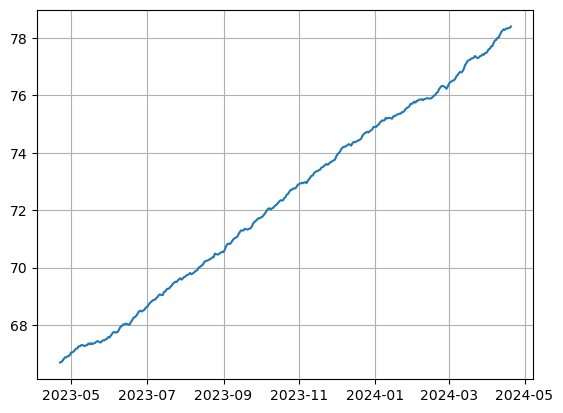

In [85]:
print("Occidental Petroleum")
precios_cierre_oxy=sim_R_oxy23.cumprod()* 66.629997
mean_oxy = precios_cierre_oxy.mean(axis=1)
plt.plot(mean_oxy)
plt.grid()

Ertex Pharmaceutics


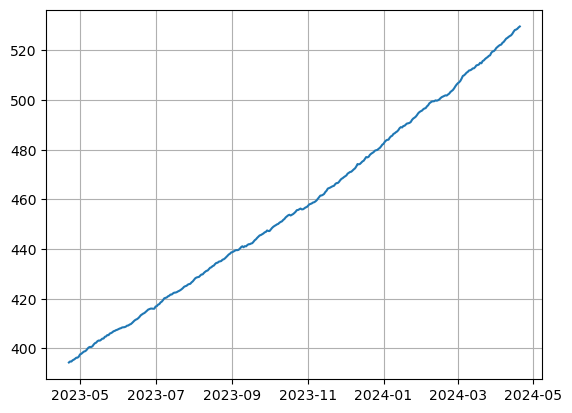

In [86]:
print("Ertex Pharmaceutics")
precios_cierre_vrtx=sim_R_vrtx23.cumprod()*394.279999
mean_vrtx = precios_cierre_vrtx.mean(axis=1)
plt.plot(mean_vrtx)
plt.grid()

In [39]:
def getClose(names, start, end):
    return yf.download(names, start=start, end=end)[["Adj Close"]]

In [73]:
aapl=getClose("AAPL", "2023-04-22", "2024-04-22")
wmt=getClose("WMT", "2023-04-22", "2024-04-22")
azo=getClose("AZO", "2023-04-22", "2024-04-22")
oxy=getClose("OXY", "2023-04-22", "2024-04-22")
vrtx=getClose("VRTX", "2023-04-22", "2024-04-22")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Apple


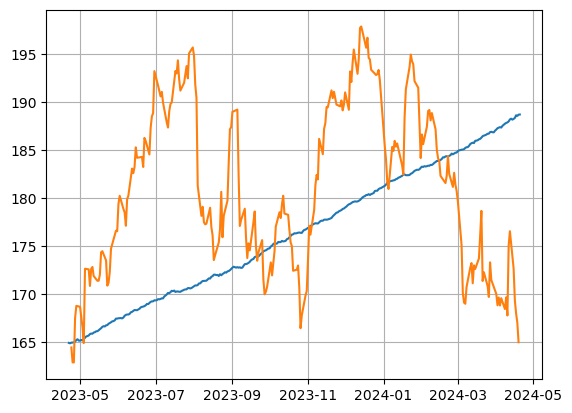

In [105]:
print("Apple")
plt.plot(mean_aapl)
plt.plot(aapl)
plt.grid()

Walmart


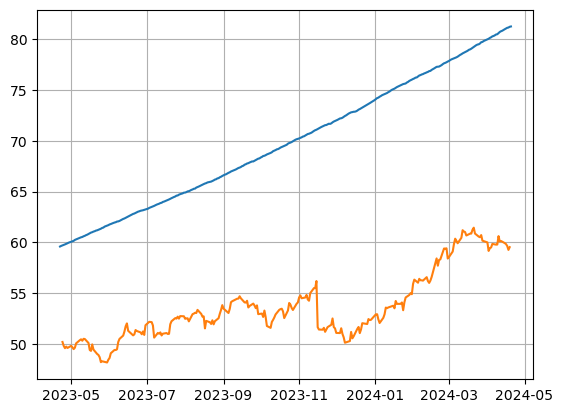

In [106]:
print("Walmart")
plt.plot(mean_wmt)
plt.plot(wmt)
plt.grid()

AutoZone


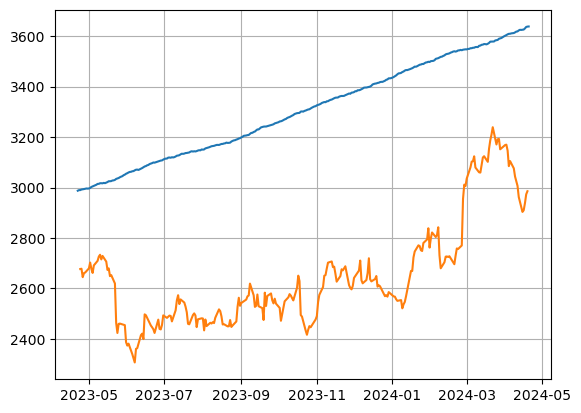

In [108]:
print("AutoZone")
plt.plot(mean_azo)
plt.plot(azo)
plt.grid()

Occidental Petroleum


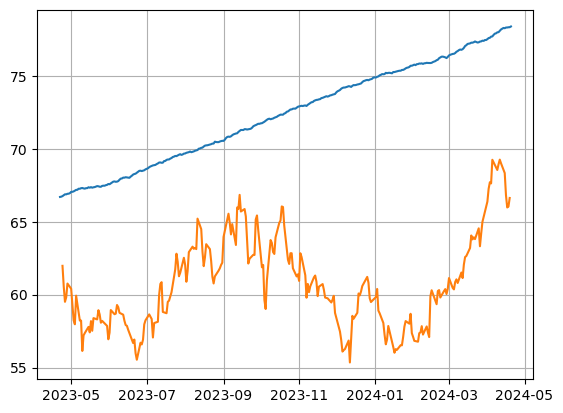

In [109]:
print("Occidental Petroleum")
plt.plot(mean_oxy)
plt.plot(oxy)
plt.grid()

Ertex Pharmaceutics


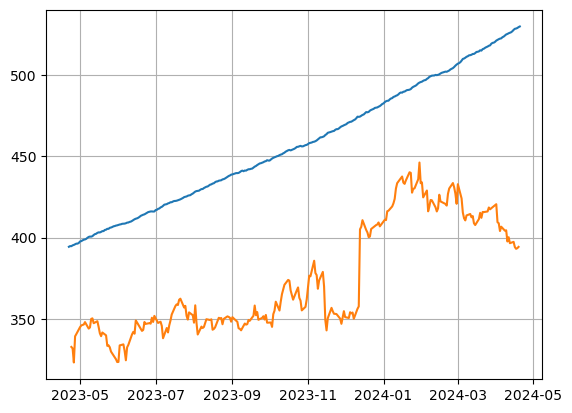

In [110]:
print("Ertex Pharmaceutics")
plt.plot(mean_vrtx)
plt.plot(vrtx)
plt.grid()

### Conclusiones.



### Referencias.

